*In this notebook:*<br>
CRISP-DM: Step 4 and Step 5<br>
**Modeling** the data to **Answer the Final Question**
___

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, \
    cross_val_score, GridSearchCV
from sklearn.metrics import r2_score


from ExploreData import sort_mean, value_counter, index_by_key


import CategoricalPrep as cp
import PrepAndModel as pam
import FeatureEngine as fe

In [2]:
df_listings = pd.read_csv('./data/listings.csv')

In [3]:
# Drop Columns without information
listings_drop_col = cp.drop_columns_analyze(df_listings)
# Transform categorical columns and make information accessable
listings_drop_trans = cp.transform_columns(listings_drop_col)
# Create new price features
listings_features = fe.new_features(listings_drop_trans)
# Encode or drop the remaining categorical columns
listings_encode = pam.feature_encoding(listings_features)
# Impute missing values
listings_impute = pam.imputation(listings_encode)


# The Host Perspective

The data set has been fully prepared for a machine learning algorithm with the functions above summarizing the necessary actions from previous notebooks.

Some preparations had already been done before we analyzed questions one and two in notebook 02. But these were only meant to make the information better accessible and not to prepare for machine learning. That is why we deal with the rest using the functions *feature_encoding* and *imputation* in the cell above.

Now we deal with question three.

## Can we make a good price estimation for a new offer to assist a (new) host?

The data-set holds some information which is usually not available for a new offer. For example reviews, or review scores. The function `drop_too_much_information` deals with that and simply drops these features from the data-set.

Below are some more functions intended to train a model and score it:


In [4]:
def drop_too_much_information(df):
    ''' Drops information unsuited for the scenario '''

    unknown_features = index_by_key(df, ['availability', 'review'])
    df = df.drop(columns=unknown_features, axis=1)
    return df

def split_xy(df, name):
    ''' Seperates the response variable 'name' from the data set '''

    X = df.drop(axis=1, columns=[name])
    y = df[name]
    return X, y

def train_score_tree(df, flag_name, test_ratio, seed, model):
    '''
    * Seperates the result 'flag_mane' form the data-set 'df',
    * splits into training and test data with 'test_ratio' and 'seed',
    * trains a ml-model 'model',
    * predicts results 'y_test_pred' and 
        'y_rain_pred' for test and training data,
    * and scores both predictions.

    INPUT:
        df (pd.DataFrame):
        flag_name (str):
        test_ratio (float):
        seed (float):
        model:

    OUTPUT:
        X_train
        X_test
        y_train
        y_test
        y_train_pred
        y_test_pred
        train_score
        test_score
    '''

    # Split into explanatory and response variables
    X, y = split_xy(df, flag_name) 
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=seed)
    # Train
    model.fit(X_train, y_train)
    # Predict and score the model
    y_test_pred = model.predict(X_test) 
    y_train_pred = model.predict(X_train)
    test_score = r2_score(y_test, y_test_pred)
    train_score = r2_score(y_train, y_train_pred)

    return X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, \
        train_score, test_score

In [5]:
df = listings_impute
# Remove information unknown about a new listing
df = drop_too_much_information(df)

### Train and Score a Decision Tree Regressor

In [6]:
# Instanciate a model
ml_tree = DecisionTreeRegressor(random_state=43)
# Train and score it
X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, train_score, \
    test_score = train_score_tree(
        df, 'price', 0.2, 43, ml_tree
        )

print( 'Score at training: ', train_score ,'\nScore at test: ', test_score)

Score at training:  1.0 
Score at test:  0.9660137641043082


### Cross Validation and Grid Search Cross Validation

In [7]:
X, y = split_xy(df, 'price') 
# Ten fold cross validation (r2_score ist the default estimator)
cv_tree = cross_val_score(ml_tree, X, y, cv=10)
cv_tree

array([0.94671675, 0.9945934 , 0.89016777, 0.92472432, 0.95687902,
       0.99211494, 0.96300121, 0.98595879, 0.92830491, 0.99110066])

**The following cell usually takes more time to compute.<br>
You can skip this one and just load the results from the csv-files as it is done in the next cell.<br>
The print statement with the current settings would be:**

*Best score:0.953077570715205<br>
Best parameters:{'criterion': 'mae', 'max_depth': 10, 'max_leaf_nodes': 100, 'min_samples_leaf': 5, 'min_samples_split': 2}*

In [8]:
# Optimize hyper parameters

# criterion{“mse”, “friedman_mse”, “mae”, “poisson”}, default=”mse”
# min_samples_split int or float, default=2
# max_depth int, default=None
# min_samples_leaf int or float, default=1
# max_leaf_nodes int, default=None

# Set a range of hyper parameters for a grid search
par_tree = {'criterion': ['mse', 'mae'],
    'min_samples_split': [2, 5, 10],
    'max_depth': [2, 6, 10],
    'min_samples_leaf': [5, 10, 20, 40],
    'max_leaf_nodes': [5, 20, 100]
    }

# Instanciate a GridSearchCV for 'ml_tree'
gridsearch_tree = GridSearchCV(ml_tree, par_tree, cv=10)
# Perform the grid search on the training data (this takes a while!)
gridsearch_tree.fit(X_train, y_train)

# Load gscv results to DataFrames
df_cv_tree = pd.DataFrame(gridsearch_tree.cv_results_)
df_best_param = pd.DataFrame(gridsearch_tree.best_params_, index=[0])
# Save results to csv
df_cv_tree.to_csv('gridsearch/grid_search_parameter_results.csv')
df_best_param.to_csv('gridsearch/grid_search_best_parameter.csv')

print('Best score:{}'.format(gridsearch_tree.best_score_))
print('Best parameters:{}'.format(gridsearch_tree.best_params_))

Best score:0.953077570715205
Best parameters:{'criterion': 'mae', 'max_depth': 10, 'max_leaf_nodes': 100, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [9]:
# Load reasults from csv to df
df_cv_tree = pd.read_csv('gridsearch/grid_search_parameter_results.csv')
df_best_param = pd.read_csv('gridsearch/grid_search_best_parameter.csv')

### Plotting The Grid Search Results

In [10]:
def plot_gs_param(df_cv, best_parameters, parameter, ax, color):
    ''' Plots one GridSearch hyper-parameter against 'mean_test_score'

    INPUT:
        df_cv (pd.DataFrame): GridSearchCV.cv_results_
        best_paramters (pd.Series): GridSearchCV.best_params_
            or 'df_cv' column with 'best mean_test_score'
            index names should match 'df_cv' column names for parameters
        parameter (str): 'the param_'-column in 'df_cv' to plot
        ax (plt.ax): the ax to plot in
        color (str): the plot color
    '''

    df = df_cv
    # drop 'paramter' from the 'best_parameter' list to keep all values
    best_parameters = best_parameters.drop(parameter)
    best_index = best_parameters.index
    # Loop through 'best_index' and filter each column for the best value
    for i in best_index:
        df = df.loc[df[i] == best_parameters[i]]
    df.plot(kind='scatter', x='mean_test_score',
            y=parameter, s=100, ax=ax, color=color)
    return


In [11]:
# Select parameter columns
parameter_cols = index_by_key(df_cv_tree, ['param_'])
# Turn 'df_best_param' into a pd.Series
best = df_best_param.rename(lambda x: 'param_'+x , axis=1).squeeze()
best = best[parameter_cols]

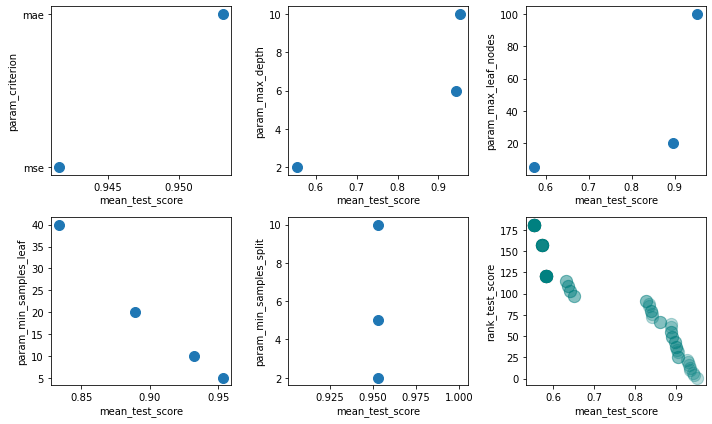

In [12]:
# Create a figure and axes
f, ax = plt.subplots(2, 3, figsize=[10,6])
ax = list(ax[0,:])+list(ax[1,:])

# Plot all paremeters against mean_test_score
for i in range(0,parameter_cols.shape[0]):
    plot_gs_param(df_cv_tree, best, parameter_cols[i], ax[i], 'C0')

# Plot the developement for GridSearchCV
df_cv_tree.plot(kind='scatter', x='mean_test_score', y='rank_test_score',
                s=150, alpha=0.1, ax=ax[5], color='teal'
                )
f.tight_layout()

The default parameters for the decision tree generated good score.<br>
But considering the model-performance for possible larger data-sets it might be sensible to fix some parameters.

The figure above plots the different parameter values for all other parameters fixed to the best result.
The minimum number of samples to make a leaf seems to be the important parameter to tune the score.<br>
It seems that the model does not need the *best* of every parameter to create a sufficient result.<br>
Below is a scored model with parameters set a bit below the extreme.
* The overfitting in training is gone (it produced a score of 1 before).
* The test-score is comparable to the first attempt.

All in all
* To recommend a price based on a given data set is possible


In [14]:
# Instanciate a model with selected parameters
ml_tree = DecisionTreeRegressor(
    random_state=43,
    criterion='mae',
    max_depth=6,
    max_leaf_nodes=50,
    min_samples_leaf=10,
    min_samples_split=10
    )

# Train and score it
X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, train_score, \
    test_score = train_score_tree(
        df, 'price', 0.2, 43, ml_tree
        )

print( 'Score at training: ', train_score ,'\nScore at test: ', test_score)


Score at training:  0.9465701876829834 
Score at test:  0.965883851610673
